# Section 3 : GitLab CI Fundamentals

## Predefined CI/CD variables reference

Usage: To tell which version is deployed

https://docs.gitlab.com/ee/ci/variables/predefined_variables.html

`CI_COMMIT_SHORT_SHA` : The first eight characters of the commit revision the project is built for.   
`CI_COMMIT_REF_SLUG` : The branch or tag name for which project is built in lowercase

## Linux Command

*sed* - stream editor for search and replace text in a file   
`sed -i 's/word1/word2/g' inputfile`


## Retry job fail

The way could be used
* Click on Retry icon
* Click on Run Pipeline

## Pipeline schedules

It's able to deploy by scheduling

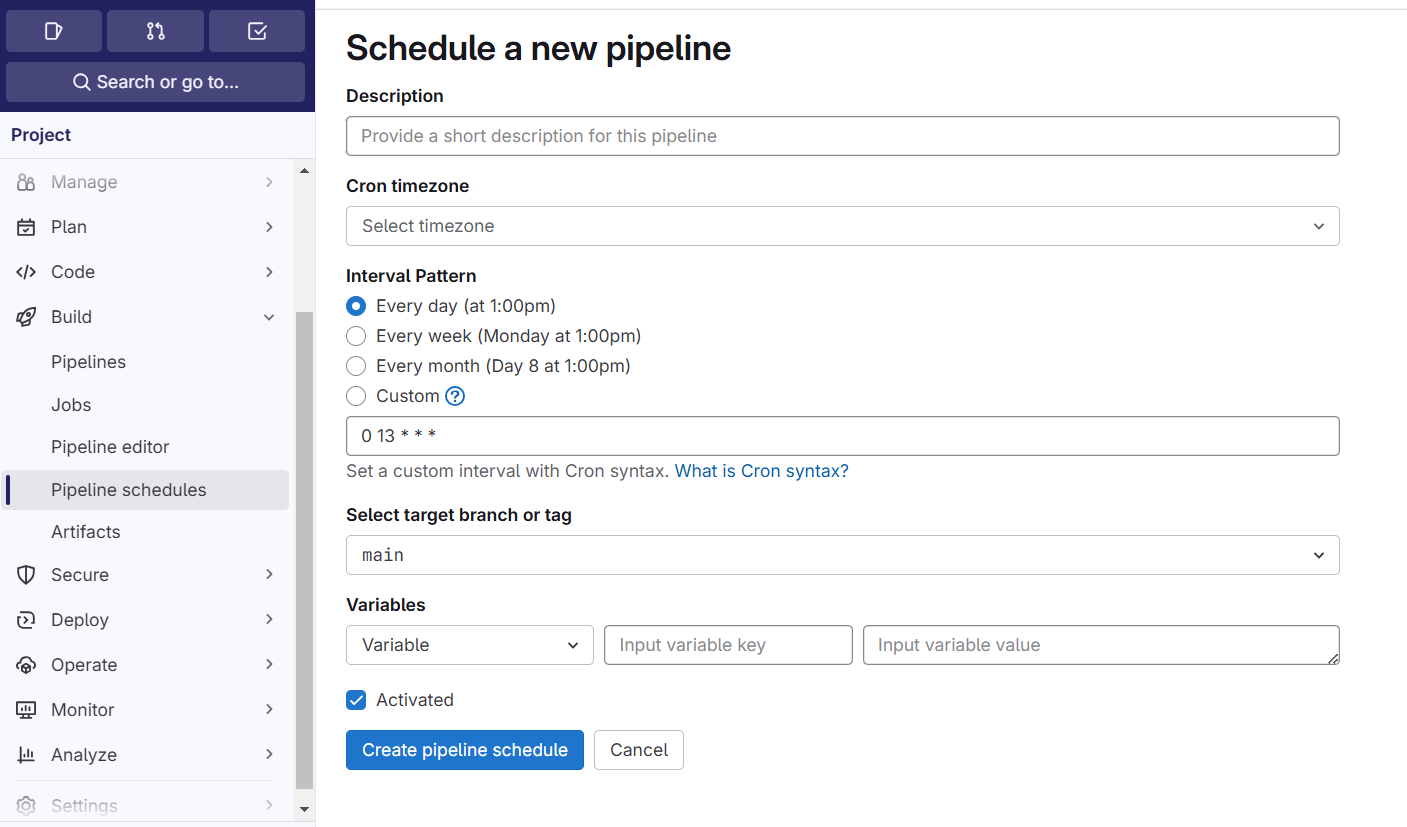

## Optimizing

By caching files that always use in other stages
```yml
cache:
  key: ${CI_COMMIT_REF_SLUG}
  paths:
    - node_modules/
```

Clean up the cache by clicking on Clear runner caches

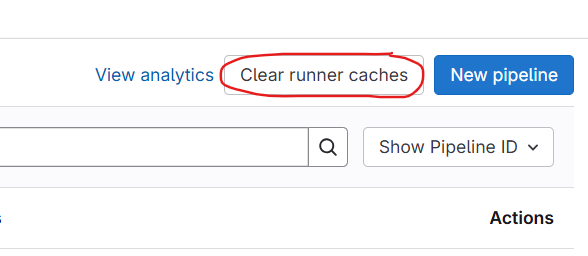

The default cache behaviour in Gitlab CI is to download the files at the start of the job execution (pull), and to re-upload them at the end (push). This allows any changes made by the job to be persisted for future runs (known as the pull-push cache policy).

https://docs.gitlab.com/ee/ci/caching/#use-a-variable-to-control-a-jobs-cache-policy

https://docs.gitlab.com/ee/ci/caching/#inherit-global-configuration-but-override-specific-settings-per-job

## Create a Job for a trigger

```yml
update cache:
  stage: cache
  # rules:
  #   - if: $CI_PIPELINE_SOURCE == "schedule"
  only:
    - schedules
```

if we want to run a job only when the pipeline is triggered by a schedule, we can configure it with:

only:

    - schedules

The same goes the other way around. If you don't want to run a job when the pipeline is triggered by a scheduled run, simply add to the respective jobs:

except:

    - schedules

## Artifact vs Cache

| Artifact | Cache |
| --- | --- |
| Output of a build tool| Not to be used to store build results |
| Can be used to pass data between stages/jobs | Temporary storage for project dependencies |

## Environment

#### Pass environment to Continuous Deployment

```yml
job:
  environment:
    name: staging
    url: http://amazonberry-staging.surge.sh
```

The deployed environment can see in the environment menu

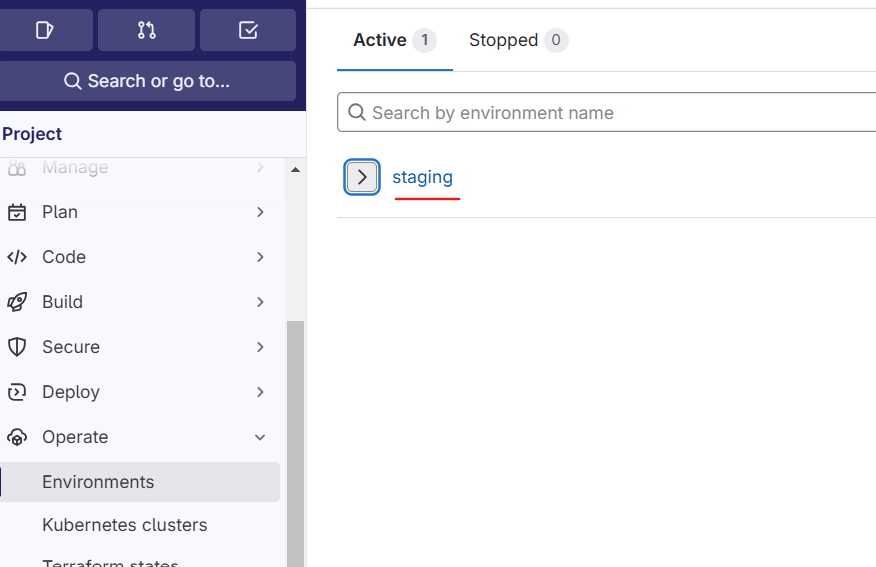

## Variable

```yml
variables:
  POLICY: pull
  STAGING_DOMAIN: amazonberry-staging.surge.sh
  PRODUCTION_DOMAIN: amazonberry.surge.sh

deploy staging:
  stage: deploy staging
  cache:
  environment:
    name: staging
    url: http://$STAGING_DOMAIN
  script:
    - npm install --global surge
    - surge --project ./public --domain $STAGING_DOMAIN
```

## Manual Deployment/Triggering Jobs

```yml
deploy production:
  stage: deploy production
  when: manual  # Do this stage by click the run button
  allow_failure: false # Won't execute next stage until this job succeed
```

## Branch

Working many branch, deploying need to only work with `main` branch. It can be done by `only`

```yml
deploy staging:
  stage: deploy staging
  only:
    - main
```

### Merge Requests

new changes that are about to be made in the master branch.

Instead of making changes directly into master, the Merge Request workflow allows you to:

* allow others to review the changes
* allows the pipeline to run once without affecting others or the master branch
* allows for additional changes to be made

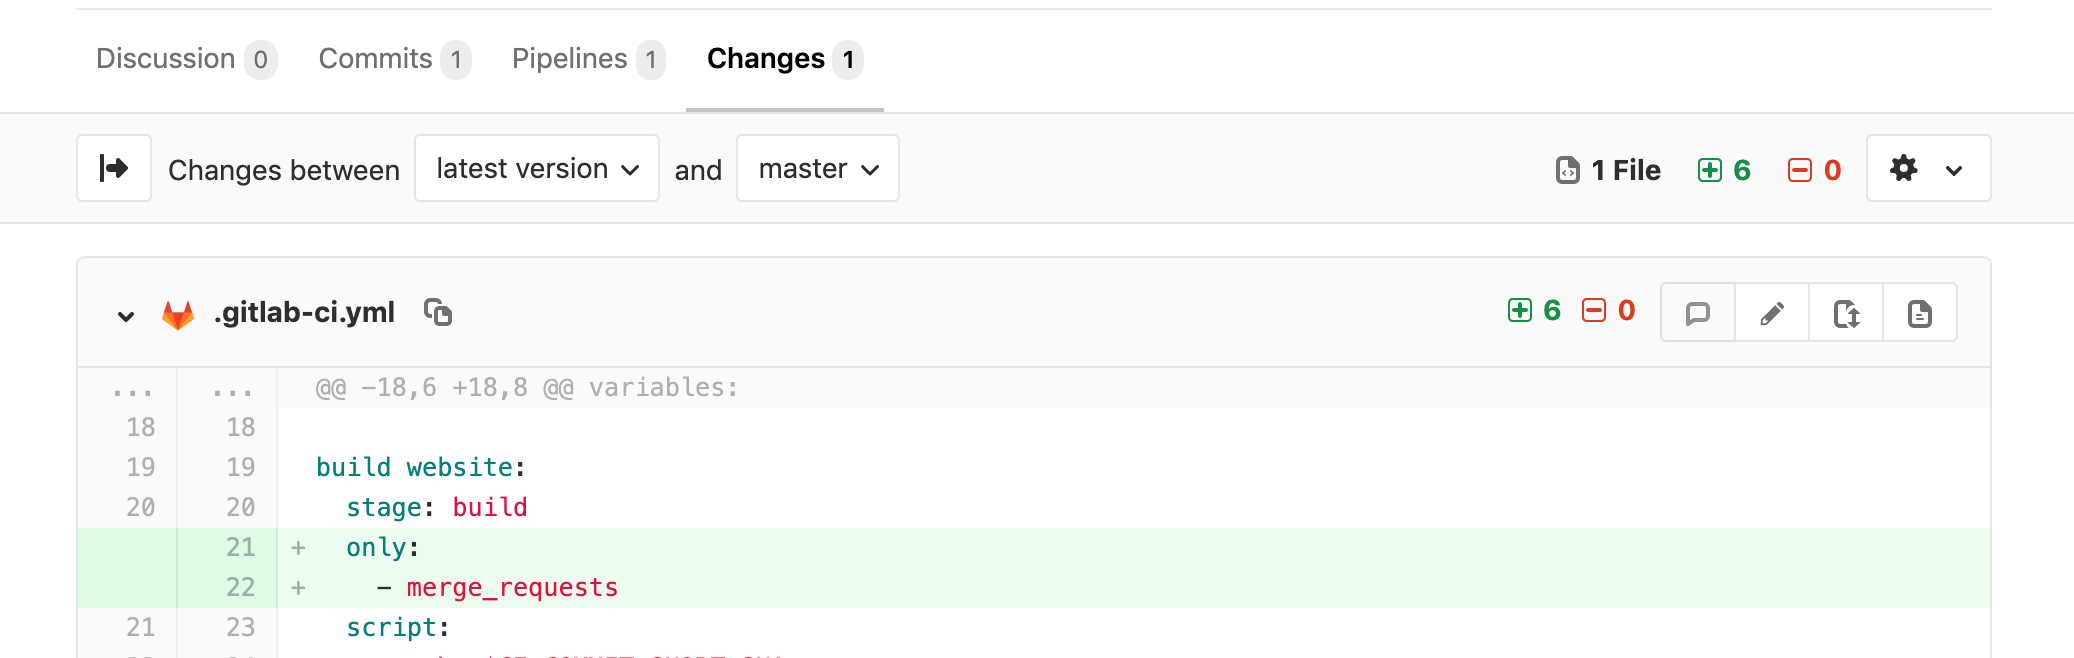

and see the status of the pipeline for a specific branch

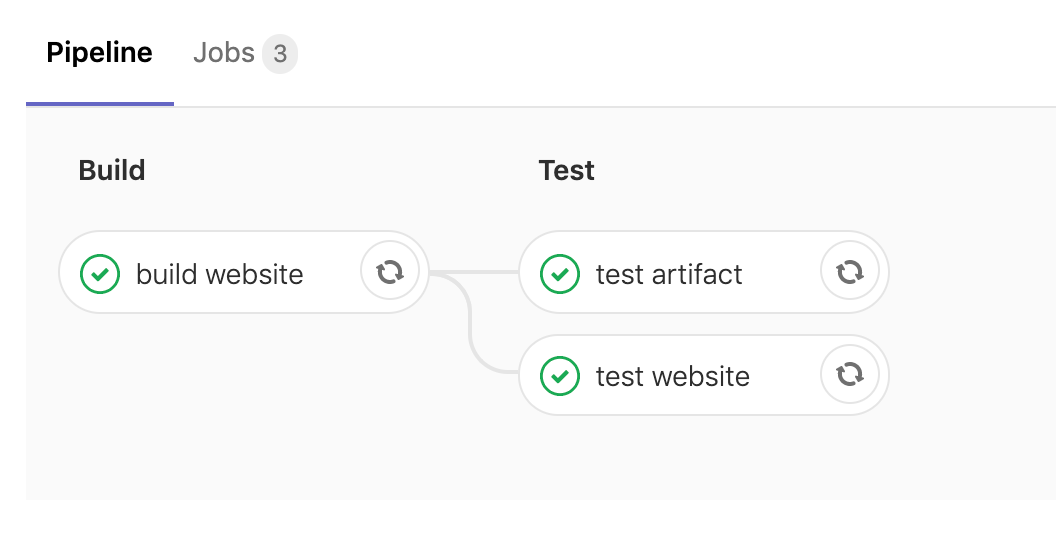

but also to give other developers the possibility of giving their feedback regarding a feature/fix before it gets merge into master.

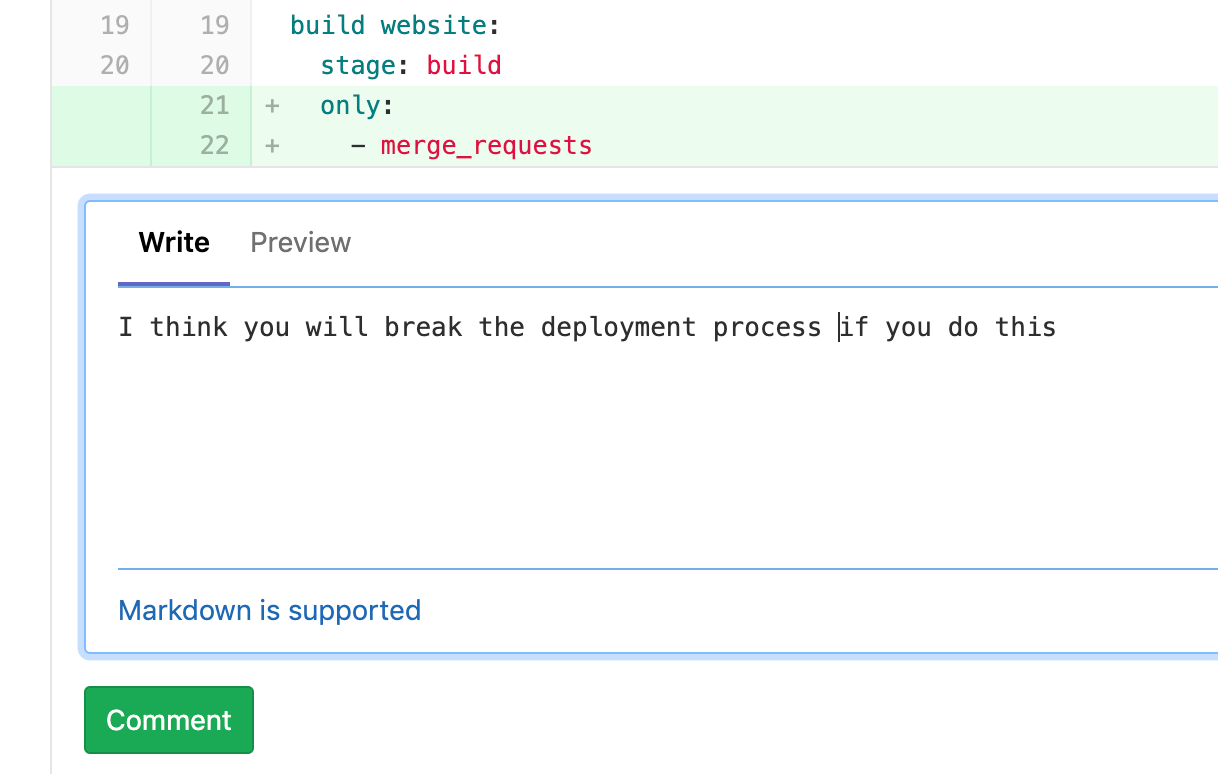

#### Configure to protect the main branch

Not allow anyone directly push and merge a commit to the branch.

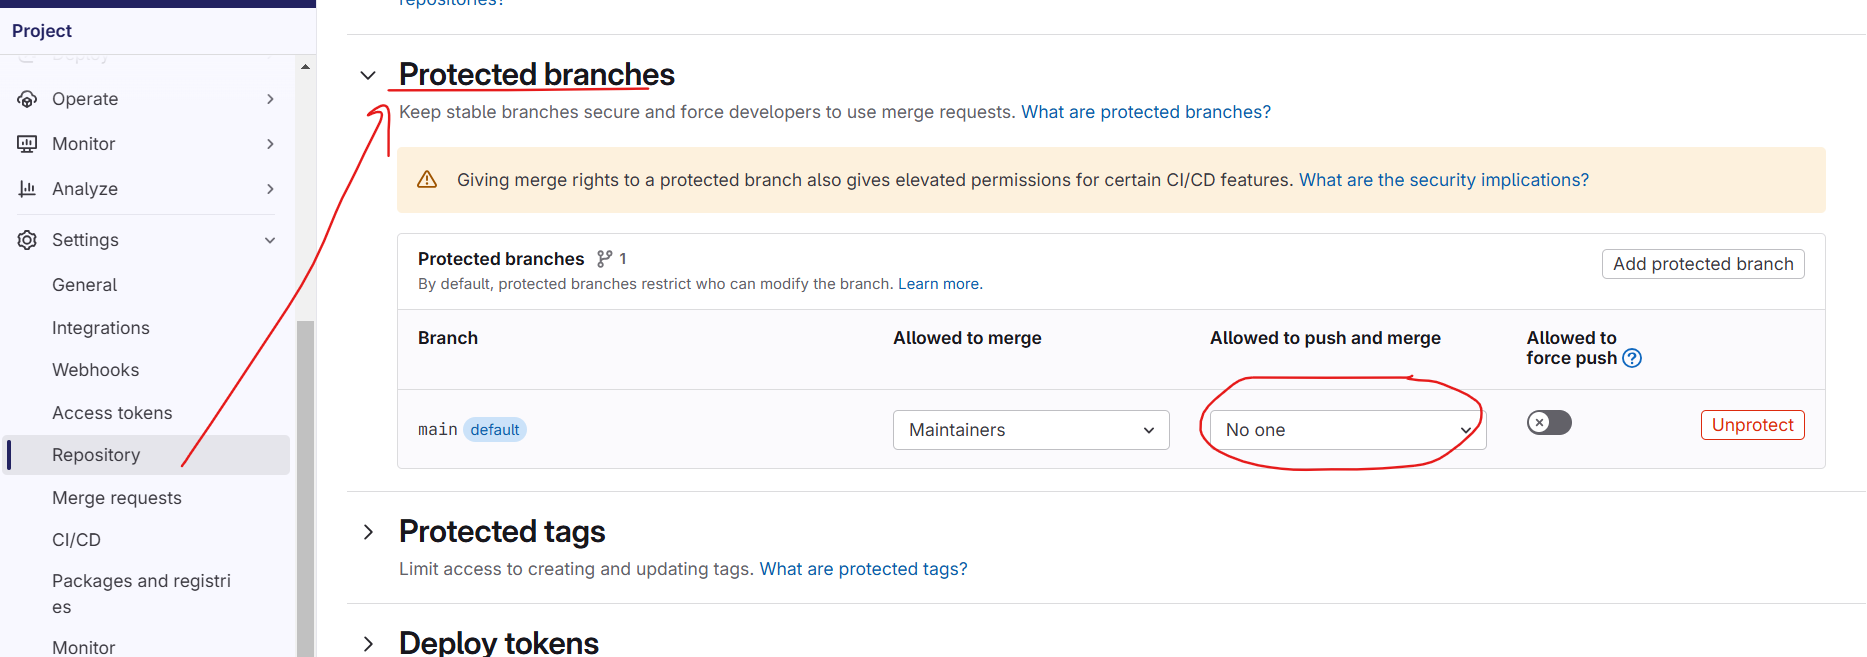

#### Configure not to show a commit that specify which a seperate branch be merged

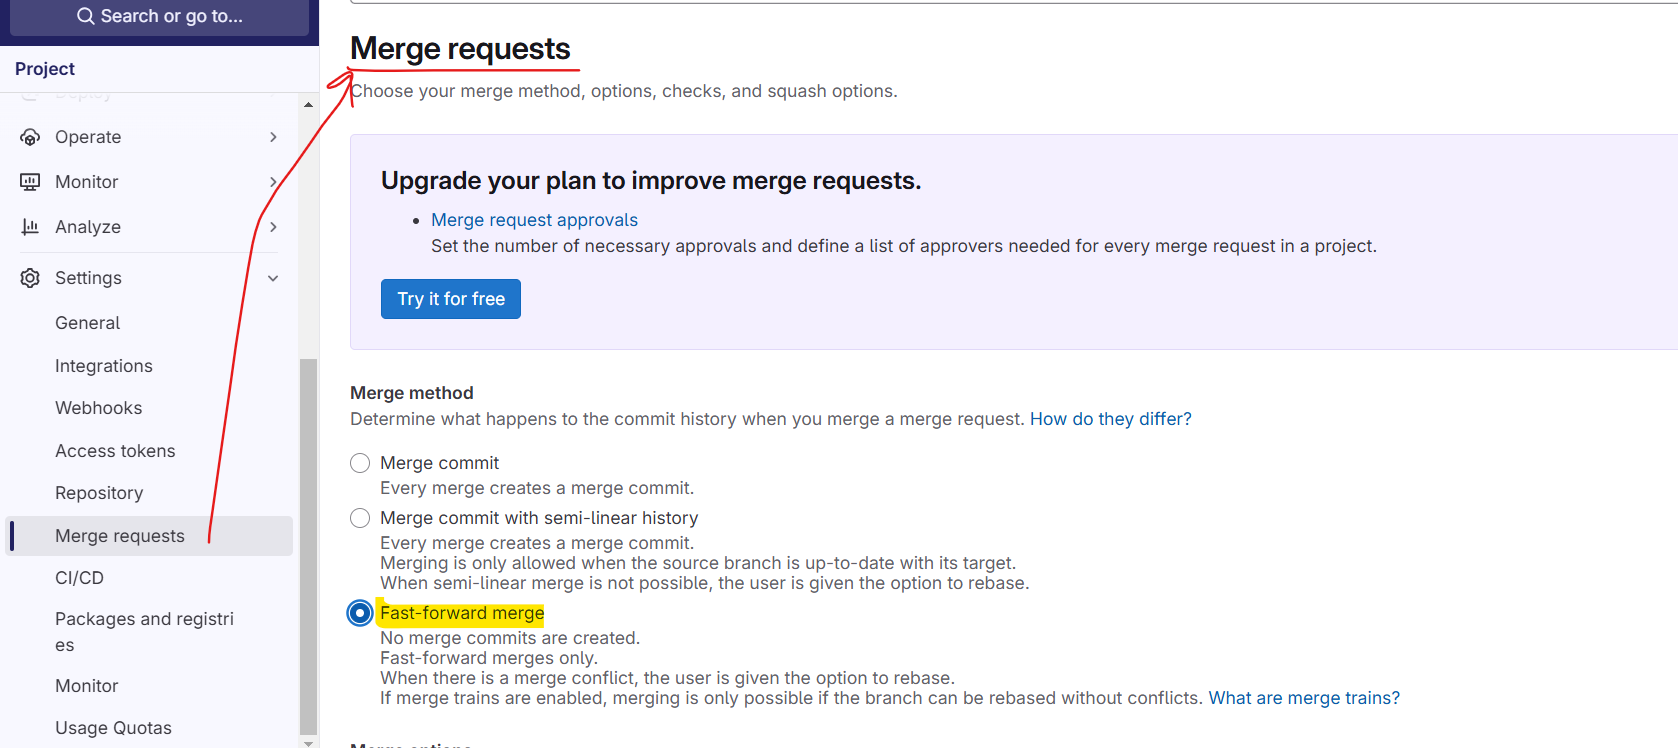

#### Configure not to merge until the latest pipeline succeeded

If you want to review the code before merge then check the `All threads must be resolved`

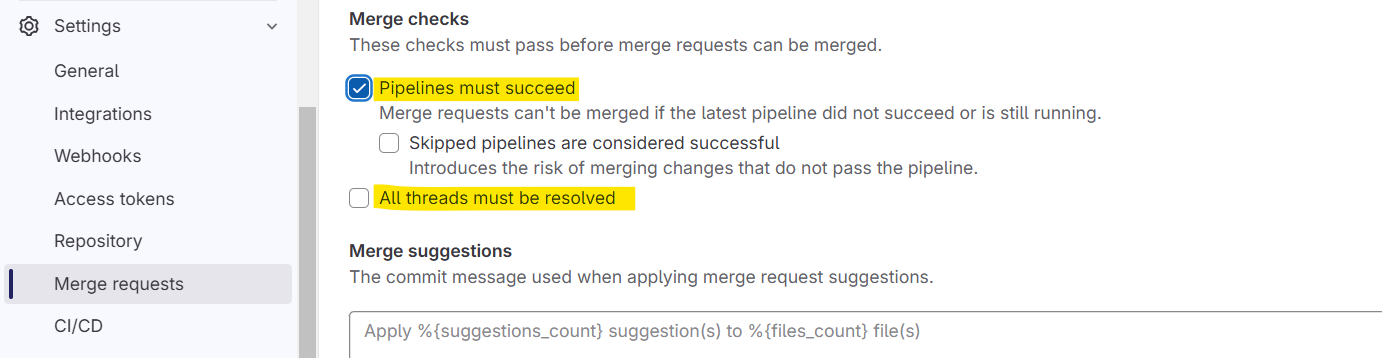

### Merge request options

In the case has no reference to the source branch because using Fast-forward method, so no need to keep the branch after being merged.

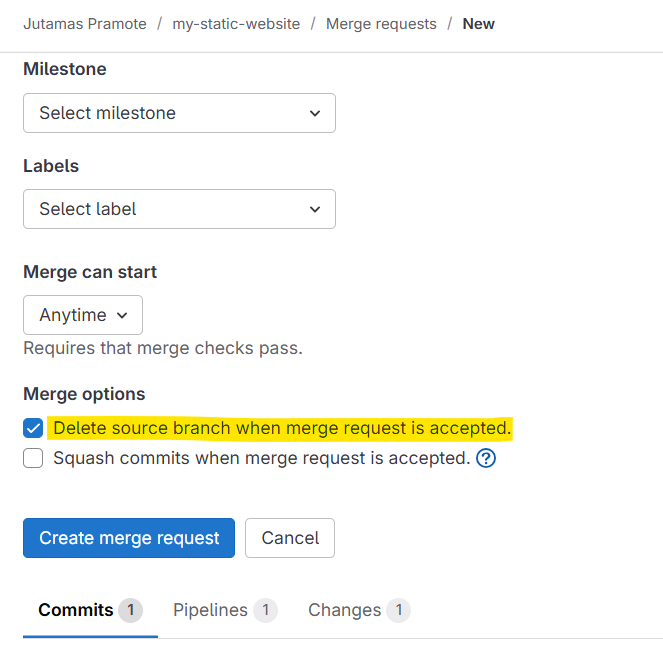

### Dynamic Environment

To review the test of each merge request

```yml
deploy review:
  stage: deploy review
  environment:
    name: review/$CI_COMMIT_REF_NAME 
    url: http://amazonberry-$CI_ENVIRONMENT_SLUG.surge.sh
  only:
    - merge_requests
  script:
    - npm install --global surge
    - surge --project ./public --domain amazonberry-$CI_ENVIRONMENT_SLUG.surge.sh
```

The domain is going to change by `CI_ENVIRONMENT_SLUG`   
`CI_COMMIT_REF_NAME` : The branch or tag name for which project is built.   
`CI_ENVIRONMENT_SLUG` : The simplified version of the environment name

#### Deleting

```yml
deploy review:
  stage: deploy review
  environment:
    name: review/$CI_COMMIT_REF_NAME 
    url: http://amazonberry-$CI_ENVIRONMENT_SLUG.surge.sh
    on_stop: stop review

stop review:
  stage: deploy review
  cache:
  environment:
    name: review/$CI_COMMIT_REF_NAME
    action: stop
  variables:
    GIT_STRATEGY: none
  when: manual
  only:
    - merge_requests
  script:
    - npm install --global surge
    - surge teardown amazonberry-$CI_ENVIRONMENT_SLUG.surge.sh

```

* Environment in `deploy review` job has a bihavior called `on_stop`. It will run `stop review` job when the action has triggered
* Environment in `stop review` job has a name match as same one in `deploy review` job which means it has related with each other. The action of the environment is `stop`
* `GIT_STRATEGY: none` means do not checkout any files (skip fetch/clone)

### Before and After Script

`script` will run between `before_script` and `after_script`